In [1]:
pip install tensorflow==2.4.1 

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==2.4.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow-gpu==2.4.1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.4.1 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.4.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:

# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Setup paths
POS_PATH = os.path.join('/Users/umesh/Desktop/Learner_space_ML/Siamese2/data', 'positive')
NEG_PATH = os.path.join('/Users/umesh/Desktop/Learner_space_ML/Siamese2/data', 'negative')
ANC_PATH = os.path.join('/Users/umesh/Desktop/Learner_space_ML/Siamese2/data', 'anchor')

In [4]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [5]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [6]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [4]:
# Import uuid library to generate unique image names
import uuid

In [5]:

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'/Users/umesh/Desktop/Learner_space_ML/Siamese2/data/anchor/3a29ae22-5193-11ef-8c5b-52dfb316b0fb.jpg'

In [8]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+450,300:300+450, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

2024-08-03 17:48:53.598 Python[19674:2417433] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


: 

In [6]:
def data_aug(img):
    data = []
    for i in range(13):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [7]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [8]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'/Users/umesh/Desktop/Learner_space_ML/Siamese2/data/anchor/3d88157c-5193-11ef-8c5b-52dfb316b0fb.jpg'


In [12]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [13]:
img = preprocess('/Users/umesh/Desktop/Learner_space_ML/Siamese2/data/positive/40f6a3b8-5193-11ef-8c5b-52dfb316b0fb.jpg')

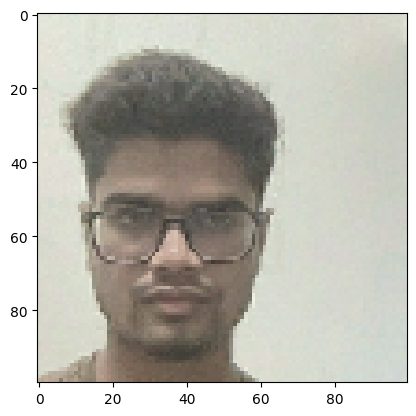

In [14]:
plt.imshow(img)

In [26]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
exampple = samples.next()

In [18]:
exampple

(b'/Users/umesh/Desktop/Learner_space_ML/Siamese2/data/anchor/3d1884dc-5193-11ef-8c5b-52dfb316b0fb.jpg',
 b'/Users/umesh/Desktop/Learner_space_ML/Siamese2/data/positive/41f85aae-5193-11ef-8c5b-52dfb316b0fb.jpg',
 1.0)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*exampple)

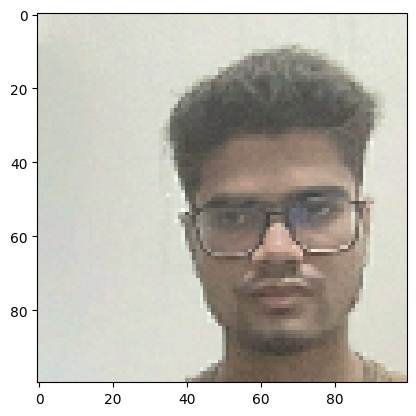

In [21]:
plt.imshow(res[0])

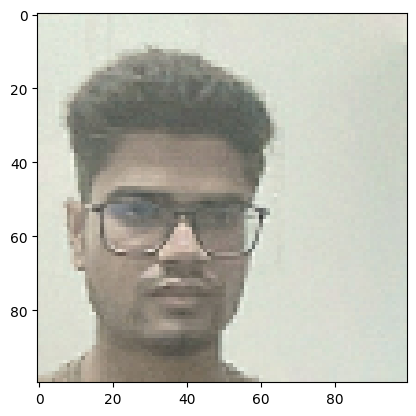

In [22]:
plt.imshow(res[1])

In [23]:
res[2]

1.0

In [24]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [25]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [27]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [28]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [29]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [30]:
embedding = make_embedding()

In [31]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [32]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [33]:
l1 = L1Dist()

In [34]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [35]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [36]:
siamese_layer = L1Dist()

In [37]:
distances = siamese_layer(inp_embedding, val_embedding)

In [38]:
classifier = Dense(1, activation='sigmoid')(distances)

In [39]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [40]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [41]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [42]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [43]:
siamese_model = make_siamese_model()

In [44]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [45]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [46]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [48]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [49]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [50]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [51]:
EPOCHS = 50

In [52]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
34/34 [==============================] - 164s 5s/step
0.0037881867 0.6478261 0.99333334

 Epoch 2/50
34/34 [==============================] - 182s 5s/step
7.15256e-07 0.95435685 0.9787234

 Epoch 3/50
34/34 [==============================] - 195s 6s/step
2.384186e-07 0.9790795 0.9957447

 Epoch 4/50
22/34 [==================>...........] - ETA: 1:15

KeyboardInterrupt: 

In [53]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [54]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [55]:
test_input.shape

(16, 100, 100, 3)

In [56]:
test_val.shape

(16, 100, 100, 3)

In [57]:
y_true.shape

(16,)

In [58]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


In [59]:
for i in range(len(y_true)):
    print(f'True labels are : {y_true}, Predicted labels are : {y_hat}')

True labels are : [1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.], Predicted labels are : [[7.5069398e-01]
 [8.3529419e-01]
 [2.2496446e-03]
 [8.1387585e-01]
 [9.9831122e-01]
 [9.9920529e-01]
 [5.6344685e-03]
 [3.5841465e-05]
 [3.2092440e-10]
 [9.4799465e-01]
 [6.1620444e-12]
 [1.2883817e-01]
 [2.6011182e-09]
 [7.1496254e-01]
 [5.8053960e-03]
 [7.6029211e-01]]
True labels are : [1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.], Predicted labels are : [[7.5069398e-01]
 [8.3529419e-01]
 [2.2496446e-03]
 [8.1387585e-01]
 [9.9831122e-01]
 [9.9920529e-01]
 [5.6344685e-03]
 [3.5841465e-05]
 [3.2092440e-10]
 [9.4799465e-01]
 [6.1620444e-12]
 [1.2883817e-01]
 [2.6011182e-09]
 [7.1496254e-01]
 [5.8053960e-03]
 [7.6029211e-01]]
True labels are : [1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.], Predicted labels are : [[7.5069398e-01]
 [8.3529419e-01]
 [2.2496446e-03]
 [8.1387585e-01]
 [9.9831122e-01]
 [9.9920529e-01]
 [5.6344685e-03]
 [3.5841465e-05]
 [3.2092440e-10]
 [9.4799465e-01]
 [6.1620

In [60]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [61]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [62]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 248ms/step
0.9913793 0.96638656


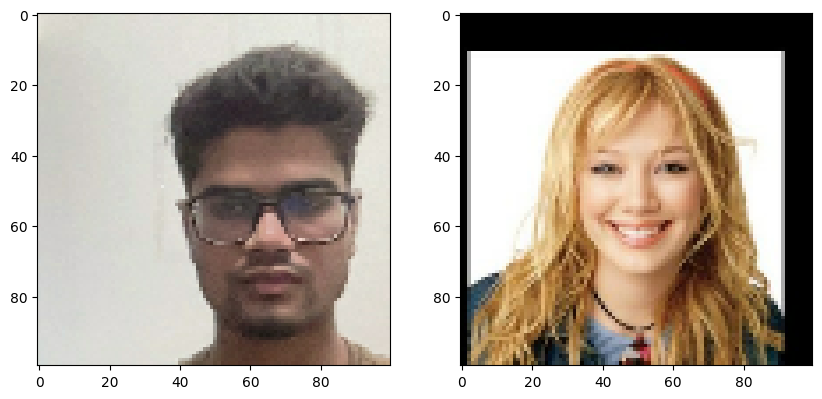

In [63]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [81]:
def view_result(img1, img2, actual_label):
    img1_t = img1.reshape(1, 100, 100, 3)
    img2_t = img2.reshape(1, 100, 100, 3)
    y_hat = siamese_model.predict([img1_t, img2_t])
    print(f'Predicted label is : {y_hat}')
    print(f'Actual label is {actual_label}')
    # Set plot size 
    plt.figure(figsize=(10,8))

    # Set first subplot
    plt.subplot(1,2,1)
    plt.imshow(img1)

    # Set second subplot
    plt.subplot(1,2,2)
    plt.imshow(img2)

    # Renders cleanly
    plt.show()
    


## taking two different images

1/1 [==============================] - 0s 173ms/step
Predicted label is : [[1.4441618e-05]]
Actual label is 0.0


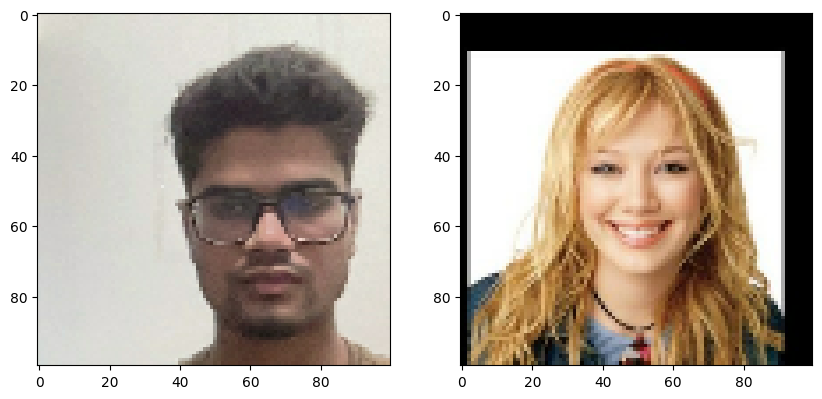

In [82]:
view_result(test_input[0], test_val[0], y_true[0])

## taking two similar images

In [91]:
img1 = test_input[0]

In [84]:
img2 = cv2.imread('/Users/umesh/Desktop/Learner_space_ML/Siamese2/data/positive/41ad4ed8-5193-11ef-8c5b-52dfb316b0fb.jpg')

In [85]:
img2 = preprocess('/Users/umesh/Desktop/Learner_space_ML/Siamese2/data/positive/41ad4ed8-5193-11ef-8c5b-52dfb316b0fb.jpg')

In [86]:
img1.shape

(100, 100, 3)

In [87]:
img2.shape

TensorShape([100, 100, 3])

In [88]:
img2 = img2.numpy()

In [89]:
img2.shape

(100, 100, 3)

1/1 [==============================] - 0s 170ms/step
Predicted label is : [[0.98998827]]
Actual label is 1


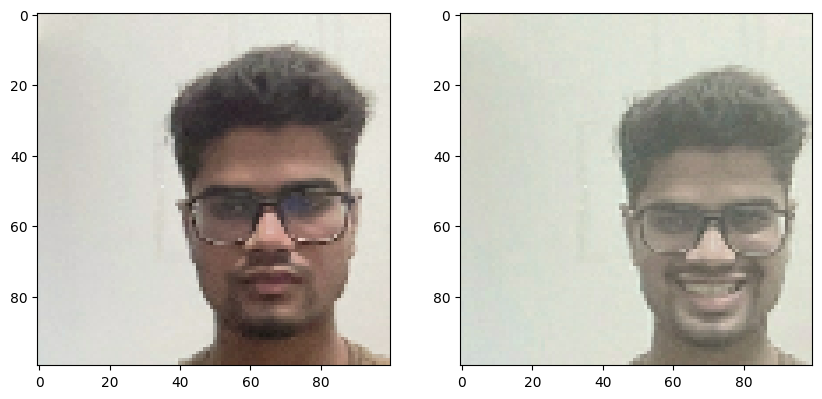

In [92]:
view_result(img1, img2, 1)

In [93]:
## Prediction is quite good ########